# Análise dos números da Mega Sena

<strike>Projeto realizado com os dados históricos dos sorteios realizados até 10/08/2019: <u>Concurso 2178</u> <br> </strike>

Projeto adaptado para trabalhar com as versões mais recentes do sorteio.

* <b>Parte 1:</b> Análise Exploratória dos Dados <br>
* <b>Parte 2:</b> Testes Estatísticos <br>
* <b>Parte 3:</b> Utilizando LSTM para prever um jogo vencedor

site: http://loterias.caixa.gov.br/wps/portal/loterias/landing/megasena/

## Análise Exploratória dos Dados

In [ ]:
# Importação dos pacotes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from config import DOWNLOAD_PATH, FILENAME

from analysis.functions import download_raffle_file
from analysis.functions import transform_html_to_csv
from analysis.functions import pre_process_dataframe
from analysis.functions import get_data_dir
from analysis.functions import print_frequency_report

In [ ]:
save_path = get_data_dir()

In [ ]:
download_raffle_file(url=DOWNLOAD_PATH, path=save_path, filename=FILENAME)
transform_html_to_csv(path=save_path, filename=FILENAME)

In [ ]:
mega_sena = pre_process_dataframe(filename=FILENAME, drop=['Cidade', 'UF'])

In [ ]:
# Definindo nome das colunas
names = ['Data', '1_n', '2_n','3_n', '4_n', '5_n', '6_n', 'Arrec', 'Sena', 'Valor_Sena', 'Quina',
         'Valor_Quina', 'Quadra', 'Valor_Quadra', 'Acumulado', 'Valor_Acumulado', 'Estimativa', 'Mega_Virada']

In [ ]:
# Alterando os nomes para facilitar a manipulação
mega_sena.columns = names

# Vizualizando as primeiras linhas
mega_sena.head() 

In [ ]:
# Verificando os tipos dos dados importados
mega_sena.info()

In [ ]:
# Realizando slice para plotagem das informações
sorteios_ano = mega_sena.groupby(mega_sena.Data.dt.year).count().iloc[:, 0]

ganhadores_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Sena']]

premios_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Valor_Sena']]

arrec_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Arrec']]

In [ ]:
# Gráficos 
ano = mega_sena.Data.dt.year.max() - 1
ano_str = str(ano)

x_lim = ano + 1

# Definindo o tamanho da figura de plotagem
plt.figure(figsize=(16,10))

# Gráfico 1
plt.subplot(221)
plt.plot(ganhadores_ano.loc[:ano_str], color='black')
plt.ylim(0, sorteios_ano.max() + 5)
plt.yticks(range(0, sorteios_ano.max(), 10))
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Ganhadores')
plt.ylabel('Número de Ganhadores')

# Gráfico 2
plt.subplot(222)
plt.plot(sorteios_ano.loc[:ano_str], color='blue')
plt.ylim(0, sorteios_ano.max() + 5)
plt.yticks(range(0, sorteios_ano.max(), 10))
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Sorteios')
plt.ylabel('Número de Sorteios')

# Gráfico 3
plt.subplot(223)
plt.plot(arrec_ano.loc['2009':ano_str], color='red')
plt.axvline(2009, 0, arrec_ano.max(), color='black')
plt.text(1999, arrec_ano.max() * 0.65, 'No_Data', size=25, color='red')
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Arrecadação')
plt.ylabel('Acumulado Anual')

# Gráfico 4
plt.subplot(224)
plt.plot(premios_ano.loc[:ano_str], color='green')
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Valor dos Prêmios')
plt.ylabel('Acumulado Anual')

plt.show()

In [ ]:
# Avaliando a distribuição de frêquencia entre os números sorteados em cada dezena
mega_dezenas = mega_sena.loc[:, '1_n':'6_n']

plt.figure(figsize=(18,9))

for i, n in enumerate(mega_dezenas.columns):
    plt.subplot(231+i)
    plt.hist(mega_dezenas[n], bins=60)
    plt.xticks(range(0, 61, 5))
    plt.yticks(range(20, 56, 5))
    plt.ylim(20, 55)
    plt.title(f'{i+1}ª Dezena')

In [ ]:
# Avaliando a distribuição das médias entre os 6 números sorteados em cada sorteio.

plt.figure(figsize=(16,8))
plt.hist(mega_dezenas.agg(func=['mean'], axis=1)['mean'], bins=30, color='gray')
plt.xticks(range(10, 58, 4))
plt.title('Distribuição das Médias de cada Sorteio')
plt.xlabel('Médias')
plt.ylabel('Frequência')
plt.show()

In [ ]:
# Preparando o dataset para avaliação geral dos números
dezenas = mega_dezenas.reset_index(level=0)

dezenas = dezenas.melt(id_vars='Concurso',
                       value_vars=['1_n', '2_n', '3_n', '4_n', '5_n', '6_n'],
                       var_name='Dezena',
                       value_name='Numero')

dezenas.sort_values(['Concurso', 'Dezena']).reset_index(drop=True).head(12)

In [ ]:
# Avaliando a distribuição de frequência geral dos números, descartando a dezena em que foi sorteado.
y_lim = dezenas.Numero.value_counts().max() + 5

plt.figure(figsize=(18,9))
plt.hist(dezenas['Numero'], bins=60, color='green')
plt.xticks(range(0, 61, 5))
plt.ylim(170, y_lim)
plt.title('Frequência Geral dos Números')
plt.xlabel('Números')
plt.ylabel('Frequência')
plt.show()

In [ ]:
# Organizando o gráfico em ordem crescente de frequência

freq = dezenas.groupby('Numero').count().iloc[:,0]

plt.figure(figsize=(16,8))
freq.sort_values().plot(kind='bar')
plt.title('Frequência dos números em ordem crescente')
plt.ylim(170, y_lim)
plt.show()

In [ ]:
print_frequency_report(frequency_dataframe=freq)

## Testes Estatíscos:

**Vamos validar a tabela de probabilidades da Caixa Econômica Federal?**

In [1]:
# Importando os pacotes
from statistics.raffler import Raffler
from statistics.gambler import Gambler
from statistics.club import GamblersClub

In [2]:
from magazine.reporter import Reporter

In [12]:
intervalo_numeros = 60              #Intevalo de números aleatórios(Ex: MegaSena = 60)
quantidade_numeros_sorteados = 6    #Quantidade de números a serem sorteados (Ex: MegaSena = 6)
quantidade_numeros_jogados = 6      #Quantidade de números escolhidos para jogar (Ex: MegaSena de 6 até 15)
tentativas = 10_000_000                #Quantidade de jogos aleatórios para tentar acertar o sorteio
amostras = 3                      #Quantidade de repetições para gerar um amostra estatística 

In [4]:
raffler = Raffler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados)

In [5]:
raffle = raffler.run()
raffle

[3, 56, 5, 35, 11, 23]

In [6]:
gambler = Gambler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados,
                  numbers_played=quantidade_numeros_jogados,
                  trials=tentativas,
                  samples=amostras,
                  raffle_numbers=raffle)

In [35]:
%time gambler.play()

100%|██████████████████████████████████████████████████████████████████| 10000000/10000000 [01:25<00:00, 116528.39it/s]



WOW! Even with 10,000,000 trials, we didn't hit all the 6 numbers!
Our best game just hit 5 numbers!

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Now, i'll play all the remaining games... Just wait! Thanks.

Wall time: 1min 27s


In [13]:
gamblers = GamblersClub(numbers_range=intervalo_numeros,
                        numbers_amount=quantidade_numeros_sorteados,
                        numbers_played=quantidade_numeros_jogados,
                        trials=tentativas,
                        samples=amostras,
                        raffle_numbers=raffle)

In [14]:
%time gamblers.play()

Wall time: 1min 34s


In [15]:
for lista in gamblers.hits_list:
    print(len(lista))

10000000
10000000
10000000


In [16]:
reporter = Reporter(gambler_hits=gamblers.hits_list,
                    numbers_played=gamblers.numbers_played)

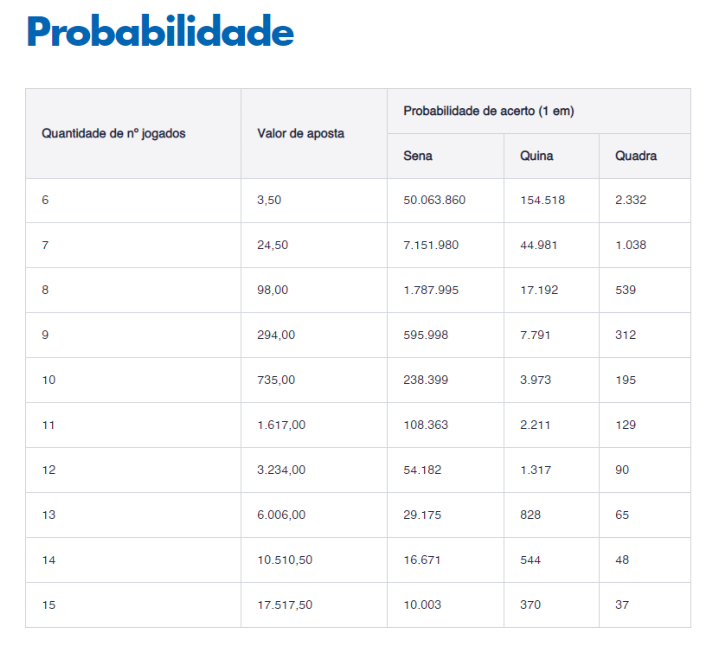

In [17]:
reporter.show_probabilities_table()

In [18]:
reporter.hit_report(number=4)

The mean score was approximately 4271 each 10,000,000 trials:

1 hit each 2,341 games played!

We have played with 6 numbers.


In [ ]:
reporter.confidence_report(number=5, confidence=0.9)

In [ ]:
print("\033[31m\033[1mred\033[m")

In [ ]:
reporter.save_hits()

In [ ]:
reporter2 = Reporter(numbers_played=gamblers.numbers_played)

In [ ]:
reporter2.load_hits(f'data/10_000_trials_30_samples.npy')

In [ ]:
reporter2.number_hit_report(number=5)

## Utilizando LSTM para prever um jogo vencedor

In [ ]:
# Importando os pacotes
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Organizando os dados para o formato correto de input
num_sorteado = np.array(jogos).flatten()

In [ ]:
# Pré-processamento e criação do dataset de treino
seq_in = []
out = []

for i in range(len(num_sorteado)-8):
    seq_in.append(list(num_sorteado[i:i+6]))
    out.append(num_sorteado[i+7])
    
X = np.array(seq_in)
y = np.array(out)

In [ ]:
# Dados de entrada organizado a cada 6 dezenas sorteadas
X = X.reshape(X.shape[0], 6, 1)

# Transformando números sorteados em categorias One Hot Encoding
hot = OneHotEncoder(sparse=False, categories='auto')
y_one = hot.fit_transform(y.reshape(len(y), 1))

In [ ]:
# Criação e treinamento do modelo
model = Sequential()

model.add(LSTM(36, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(120, activation='elu'))
model.add(Dense(y_one.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.fit(X, y_one, epochs=10, verbose=1)

In [ ]:
# Resumo do modelo
model.summary()

In [ ]:
# Análise preditiva
numeros_previstos = []

for i in range(len(jogos)):
    X_teste = np.array(jogos[i])
    X_teste = X_teste.reshape(1, X_teste.shape[0], 1)
    predicted = model.predict(X_teste)
    numeros_previstos.append(np.argmax(predicted))

# Tentamos organizar os números para prever as dezenas mais prováveis de serem sorteadas.
numeros_previstos = pd.Series(numeros_previstos).unique()
numeros_previstos = list(numeros_previstos)
numeros_previstos.sort()

In [ ]:
# Numeros previstos como mais provaveis:
print(numeros_previstos)

q_mais = 0
q_menos = 0

for n in numeros_previstos:
    if n in mais:
        q_mais += 1
    elif n in menos:
        q_menos += 1
        
print(f'\nTemos {q_mais} dos números previstos entre os mais frequentes.')
print(f'\nTemos {q_menos} dos números previstos entre os menos frequentes.')

In [ ]:
prev = []

for jogo in jogos:
    c = 0
    for n in jogo:
        if n in numeros_previstos:
            c += 1
    if c == 6:
        print(jogo)
        break
    prev.append(c)

print(f'''Utilizando os {len(numeros_previstos)} números mais prováveis previstos pelo modelo,
tivemos uma média de acerto de {sum(prev)/len(prev):.2f} números considerando todos os 2178 sorteios.''')

## Conclusão:

* Como o fenomeno dos sorteios é completamente aleatório, o modelo não foi capaz de prever os números de forma acertiva. 

* Para avaliar o aprendizado do modelo, a expectativa era que ele fosse enviezado para buscar os números mais frequentes, o que não se mostrou na análise, sendo que 4 dos 12 estão presentes entre os números menos frequentes e apenas 1 entre os mais. 


# FIM!